In [62]:
import numpy as np
import mc_nsh
import nsh
import matplotlib.pyplot as plt
import time
from math import floor
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Matin's implementation of the NSH algorithm
def NSH(f):
  m = np.mean(f)
  G = 0
  if len(f.shape) == 1:
    f = np.reshape(f, (-1, 1))
  d1 = f.shape[0]
  d2 = f.shape[1]
  h = np.hstack((f,f))
  f_ = np.vstack((h,h))
  i = 0

  G_array  = np.zeros(d1*d2*d1*d2)
  for y in range(d2):
      for ly in range(1, d2+1):
          for x in range(d1):
              for lx in range(1, d1+1):
                  range_x = np.arange(x, x+lx)
                  range_y = np.arange(y, y+ly)
                  G += abs(np.mean(f_[np.ix_(range_x,range_y)])-m)
                  G_array[i] = G
                  i +=1
                  
  #print('G = ', G)
  return G*2/(m*d1*d2*(3*d1*d2-d1-d2-1))

### Unit test my naive looping Fortran method against Matin's code

Testing Array

In [ ]:
array_dim = 10 
a = np.random.rand(array_dim, array_dim)

In [3]:
# time how long it takes for the NSH algorithm to run
def time_python_NSH(f):
  start = time.time()
  NSH(f)
  end = time.time()
  return end - start

# time how long it takes for the MC-NSH algorithm to run
def time_fortran_NSH(f):
  start = time.time()
  nsh.normalizedspatialhet(f)
  end = time.time()
  return end - start

In [4]:
nsh_python = NSH(a)
nsh_fortran = nsh.normalizedspatialhet(a)

abs_err = abs(nsh_fortran - nsh_python)
rel_err = abs(nsh_fortran - nsh_python) / nsh_python

print(f'Absolute error: {abs_err}')
print(f'Relative error: {rel_err}')

Absolute error: 8.326672684688674e-17
Relative error: 1.2956304224531906e-15


#### Timings and speedup for Fortran implementation

In [5]:
time_python = time_python_NSH(a)
time_fortran = time_fortran_NSH(a)

print(f'Time for Python NSH: {1000*time_python} ms')
print(f'Time for Fortran NSH: {1000*time_fortran} ms')
print(f'Speedup: {time_python / time_fortran}')

Time for Python NSH: 298.43759536743164 ms
Time for Fortran NSH: 0.3020763397216797 ms
Speedup: 987.9542225730071


### Unit test Monte Carlo code against Fortran routine

Testing array

In [87]:
array_dim = 100 
a = np.zeros((array_dim, array_dim))
a[25, 25] = 1
#a = np.random.rand(array_dim, array_dim)

In [88]:
#nsh_true = nsh.normalizedspatialhet(a)
nsh_true = 1

In [89]:
max_permutes = array_dim**4
n_estimates = 100
estimates = np.zeros(n_estimates)
rel_errs = np.zeros(n_estimates)
permutes = np.logspace(1, floor(np.log10(max_permutes)), n_estimates, dtype=int)
for i, p in enumerate(permutes):
    if i % 10 == 0:
        print(f'Iteration: {i}')
    nsh_est_avg = 0
    nsh_estimates = np.zeros(10)
    rel_err_estimates = np.zeros(10)
    for j in range(10):
        nsh_est = nsh.montecarlospatialhet(a, n_permutes=p)
        rel_err = abs(nsh_est - nsh_true) / nsh_true
        nsh_estimates[j] = nsh_est
        rel_err_estimates[j] = rel_err
    nsh_est = np.mean(nsh_estimates)
    rel_err = np.mean(rel_err_estimates)

    estimates[i] = nsh_est
    rel_errs[i] = rel_err


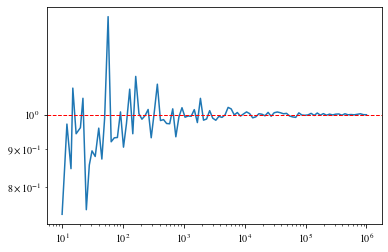

In [84]:
plt.plot(permutes, estimates)
plt.axhline(nsh_true, color='r', ls='--', lw=1)
plt.yscale('log')
plt.xscale('log')

In [85]:
def formatPlotGrid(ax):
    """Helper function for formatting plot grid
    """
    ax.grid(which = "major", linewidth = 1, axis='y', ls="dotted", dashes=(.5,6), c='#414141', alpha=.5)
    ax.grid(which = "minor", linewidth = 1, axis='y', ls="dotted", dashes=(.5,6), c='white')#, alpha=.5)
    ax.grid(which = "minor", linewidth = 1, axis='x', ls="dotted", dashes=(.5,6), c='#414141', alpha=.4)
    ax.grid(which = "major", linewidth = 1, axis='x', ls="dotted", dashes=(.5,6), c='#414141')
    ax.tick_params(axis='both', labelsize=13, which='major', direction='in', top=True, right=True, bottom=True, left=True)
    ax.tick_params(axis='both', which='minor',direction='in',top=True, right=True, bottom=True, left=True)

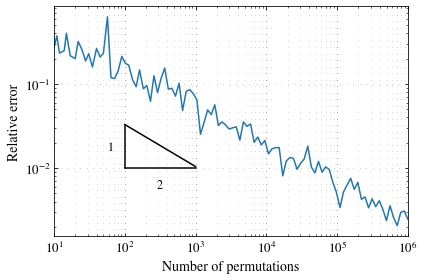

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(permutes, rel_errs)

def func(a, X):
    return a*X**(-0.5)

# draw slope triangle
logx_min = 2
logx_max = 3
logy_min = -2
logy_max = -1.5
n_points = 100
X_vals = np.logspace(logx_min, logx_max, n_points)
Y_vals = np.logspace(logy_min, logy_max, n_points)
const_arr = np.zeros(n_points,)

const_arr[:] = 10**logy_min
ax.plot(X_vals, const_arr, c='k')

const_arr[:] = 10**logx_min
ax.plot(const_arr, Y_vals, c='k')

ax.plot(X_vals, func(a=.33, X=X_vals), c='k') # a: point where line intersects yaxis
ax.text(x=10**(logx_min+0.5), y=10**(logy_min-0.2), s='2', fontsize=12, horizontalalignment='center', verticalalignment='center')
ax.text(x=10**(logx_min-.2), y=10**(logy_min+0.25), s='1', fontsize=12, horizontalalignment='center', verticalalignment='center')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(permutes[0], permutes[-1])

formatPlotGrid(ax)


ax.set_ylabel('Relative error', fontsize=14)
ax.set_xlabel('Number of permutations', fontsize=14)
plt.tight_layout()
plt.savefig('monte-carlo-sh-convergence.pdf', format='pdf')
